# Metadata EDA

Analysis by Jeremy Mann

* By far the most important take away is this data set is insanely biased towards men. Only a single woman! Very disappointing, so many questions will be left unexamined. I wonder if the researchers even noticed? They made no mention of the massive bias in their paper. This feels irresponsible...

* This fishing expedition came up pretty empty. TBH I found this metadata relatively uninspriring. Maybe I'll return to it at a later stage? It does have data on injuries, but the fact that none of the "elite" runners have injuries makes me wonder what they meant by injury... I have a hard time believing that the elite runners have no chronic myofascial conditions.



In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Load the data and do some minor string-to-number wrangling:

In [2]:
def wrangle_meta_data(filepath):
    meta = pd.read_csv(filepath, delimiter = '	')
    meta.drop(columns = 'FileName', inplace = True)
    meta.drop_duplicates(inplace = True, keep = 'first')
    meta.set_index('Subject', inplace = True)
    replace_dict = { '16-25 km': 0, '26-35 km': 1, '36-45 km': 2, '> 45 km': 3, '>45 km': 3,
                'Yes': 'Injured', 'No':"Not Injured", 
                'Forefoot': 2, 'Midfoot' : 1, 'Rearfoot' : 0}
    meta = meta.replace(to_replace=replace_dict)
    return meta
    

In [4]:
meta = wrangle_meta_data('../data/raw_data/RBDSinfo.txt')
meta.columns

Index(['Age', 'Height', 'Mass', 'Gender', 'Dominance', 'Level', 'Experience',
       'SessionsPerWk', 'Treadmill', 'Aslphalt', 'Grass', 'Trail', 'Sand',
       'Concrete', 'SurfaceAlt', 'RunGrp', 'Volume', 'Pace', 'RaceDist',
       'Injury', 'InjuryLoc', 'DiagnosticMed', 'Diagnostic', 'InjuryOnDate',
       'ShoeSize', 'ShoeBrand', 'ShoeModel', 'ShoePairs', 'ShoeChange',
       'ShoeComfort', 'ShoeInsert', 'RFSI25', 'RFSI35', 'RFSI45', 'LFSI25',
       'LFSI35', 'LFSI45', 'RThomas', 'LThomas', 'ROber', 'LOber', 'RHIPABD',
       'LHIPABD', 'RHIPEXT', 'LHIPEXT', 'RHIPER', 'LHIPER', 'RHIPIR'],
      dtype='object')

## Distributions of Gender

Let's examine the distribution of genders:

In [5]:
meta['Gender'].value_counts()

M    27
F     1
Name: Gender, dtype: int64

Woah, that's pretty imbalanced.

## Level vs. Injury

Most of the subjects were only a few athletes were elite, and none had "injuries".

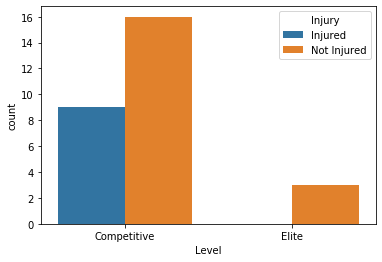

In [6]:
sns.countplot(x = 'Level', hue = 'Injury', data = meta)

## General Demographics and Injury

At least the demographic distribution looks good. Only vague take away is the appearance of a correlation between height and injury, which aligns with conventional wisdom

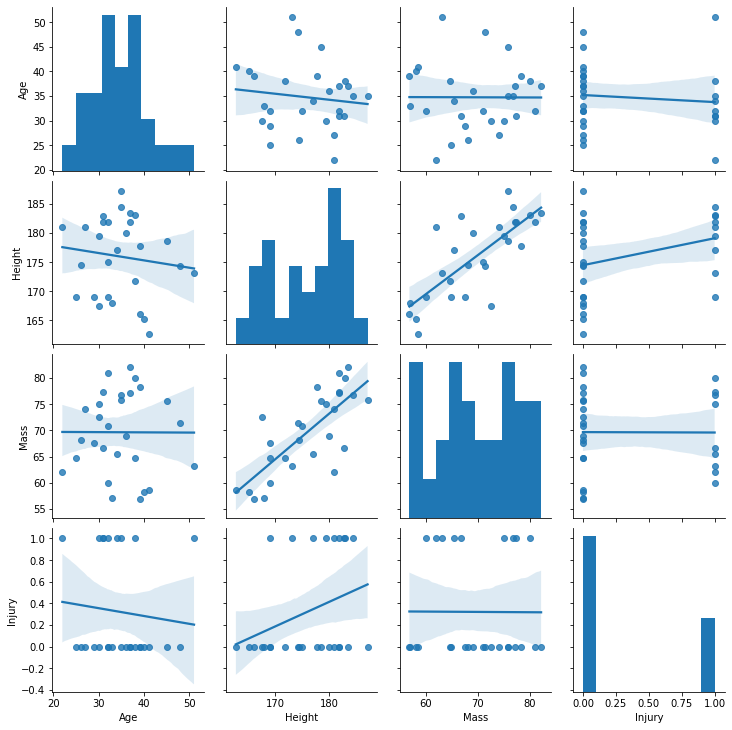

In [36]:
sns.pairplot(data = meta[['Age', 'Height', 'Mass','Injury']], kind = 'reg')

## Training Volume vs Injury

Again, nothing interesting.

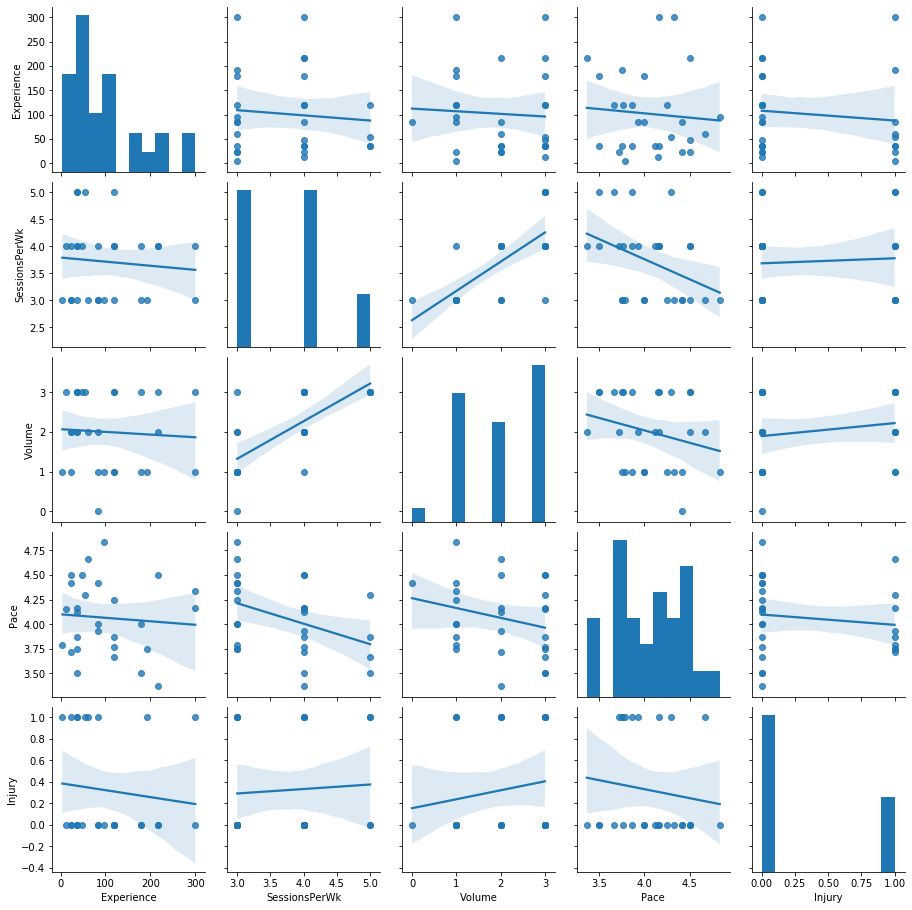

In [39]:
i_meta = meta[['Experience', 'SessionsPerWk', 'Volume', 'Pace', 'Injury']]

sns.pairplot(i_meta, kind = 'reg')

Let's do a sanity check of pairwise relationships and 

## Running Surfaces vs Injury

For funnzies let's look at the relationship between the surfaces people run on and injuries. Most of the surface types were poorly represented, so I stuck with the most popular ones along with the total volume.

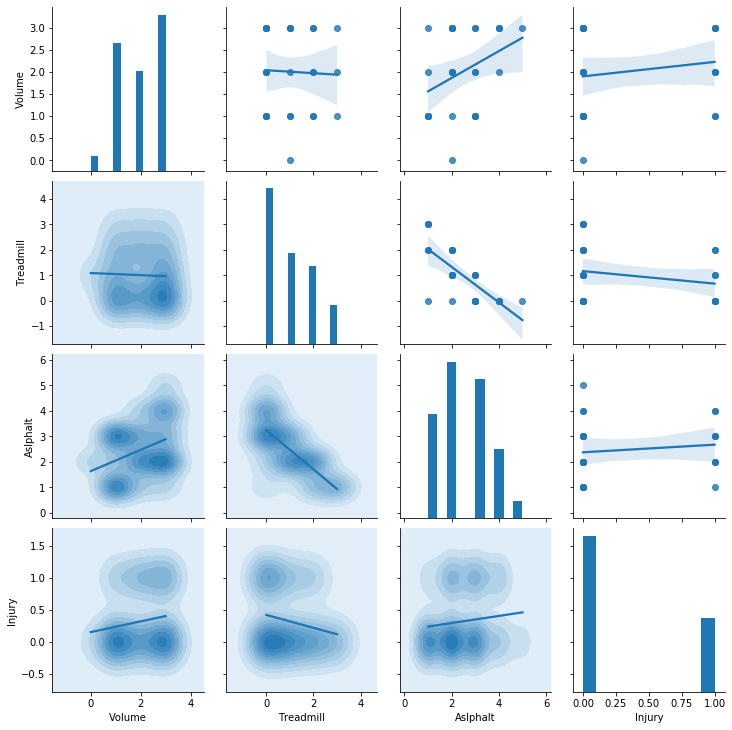

In [29]:
surface_inj = meta[['Volume', 'Treadmill', 'Aslphalt', 'Injury']]

pairplot = sns.pairplot(data = surface_inj,
                       kind = 'reg')
pairplot.map_lower(sns.kdeplot, shade=True)

Not very interesting. Below emphasizes the lack of interesting correlations. 

Text(0.5, 1, '(Pearson) Correlations')

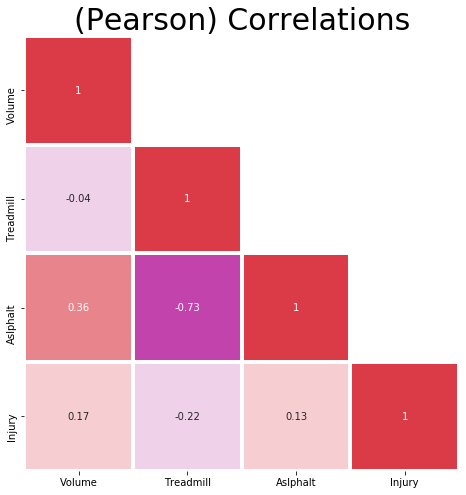

In [30]:
plt.figure(figsize = (8,8))
corr = np.round(surface_inj.corr(), decimals = 2) # dataframe of correlations
mask = np.triu(np.ones_like(corr, dtype=np.bool), k = 1)
sns.heatmap(corr,  
            mask = mask, 
            cmap = sns.diverging_palette(320, 10), 
            vmin = -1, 
            vmax = 1, 
            linewidths = 3,
            square=True,
            cbar = False,
            annot=True ) 
plt.title('(Pearson) Correlations', fontdict = {'fontsize' : 30})

## Foot Strike vs Injury
For funnzies, I'm going to examine the relationship between how the runner's feet strikes the ground and injury using a simple linear regression model. I'm not even going try to act like any of this is statistcally significant, so I won't bother wth train-test sptit or cv.


For simplicity, I'm going to restrict my attention to right foot dominant runners.

In [10]:
def footstrike_v_injury_wrangle(filepath):
    meta = wrangle_meta_data(filepath)
    data = meta[ [ 'RFSI25', 'RFSI35', 'RFSI45', 'LFSI25',
        'LFSI35', 'LFSI45', 'Dominance', 'Injury'] ]
    rdata = data[data['Dominance'] == 'R'].copy()
    rdata.drop(columns = "Dominance", inplace = True)
    right_data = rdata[['RFSI25', 'RFSI35', 'RFSI45', 'Injury']]
    left_data = rdata[[ 'LFSI25', 'LFSI35', 'LFSI45', 'Injury']]
    column_names = ['2.5 m/s', '3.5 m/s', '4.5 m/s', 'Injury']

    column_names = ['11 min/mi', '8 min/mi', '6 min/mi', 'Injury']
    right_data.columns = column_names
    left_data.columns = column_names
    right_data.insert(0, 'Side', 'Right')
    left_data.insert(0, 'Side', 'Left')

    ftstrike_vs_injury_df = pd.concat([left_data, right_data])
    return ftstrike_vs_injury_df


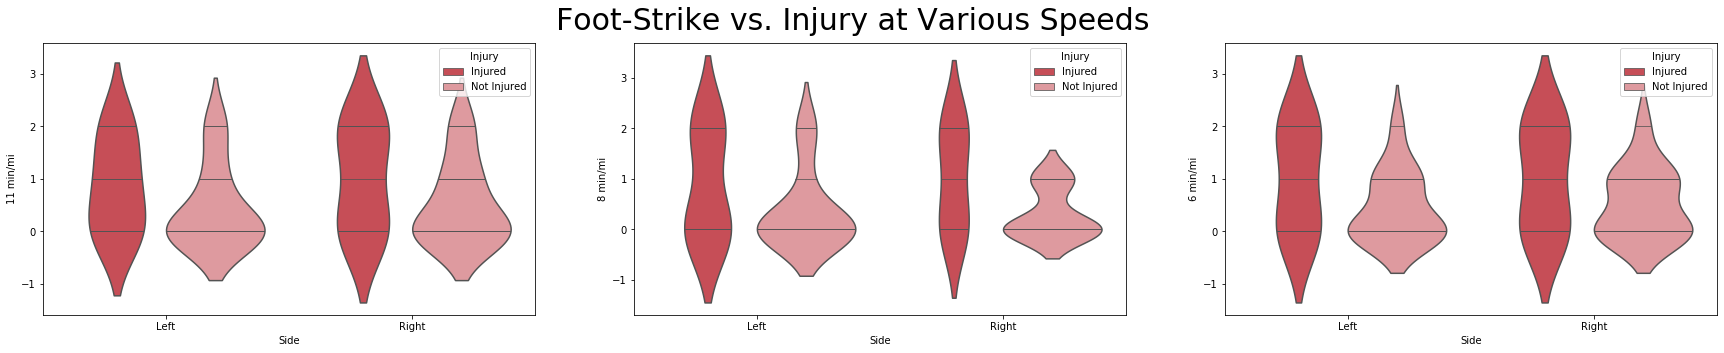

In [23]:
def footstrike_v_injury_figure(filepath):
    ftstrike_vs_injury_df = footstrike_v_injury_wrangle(filepath)
    
    fig, ax = plt.subplots(1,3, figsize = (30, 5))
    fig.suptitle('Foot-Strike vs. Injury at Various Speeds', fontsize = 30)

    for i in range(1, 4):
        sns.violinplot(x = 'Side', 
                   y = ftstrike_vs_injury_df.columns[i], 
                   hue = 'Injury', 
                    inner = 'stick',
                   palette= sns.diverging_palette(10, 220, sep=80, n=7),
                   data = ftstrike_vs_injury_df, 
                   ax = ax[i-1]
                      )
        ax[i-1].grid(False)
    return fig

footstrike_v_injury_figure = footstrike_v_injury_figure('../data/raw_data/RBDSinfo.txt')
footstrike_v_injury_figure.savefig('../figures/footstrike_v_injury_figure')